# How to make a submission using the Run-Length Encoding format

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pathlib import Path
data_path = Path('/kaggle/input/google-research-identify-contrails-reduce-global-warming')

## Run-Length Code

The following is code to both encode and decode RLE format.

IMPORTANT: Unlike many previous Kaggle competition, empty predictions must be encoded as `'-'`. Empty string / null predictions will cause an error in scoring. The code below handles this change.

In [2]:
def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s


def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formatted (start length)
              empty predictions need to be encoded with '-'
    shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''

    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    if mask_rle != '-': 
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
    return img.reshape(shape, order='F')  # Needed to align to RLE direction

## Create a naive submission

We'll use just `band_08` and predict that the 1000 pixels with the highest numerical values are contrails.

In [3]:
test_recs = os.listdir(data_path / 'test')
print(test_recs)

['1002653297254493116', '1000834164244036115']


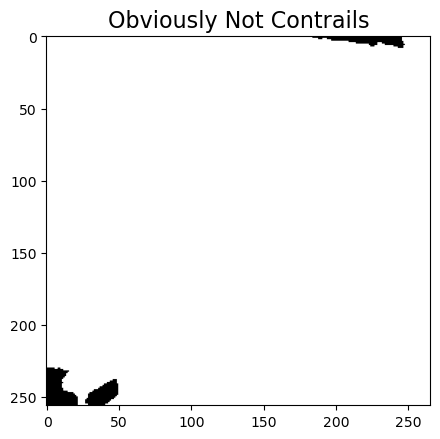

In [4]:
n = 1000
band_08 = np.load(data_path / 'test' / test_recs[0] / 'band_08.npy').sum(axis=2)
# https://stackoverflow.com/a/57105712
preds = np.c_[np.unravel_index(np.argpartition(band_08.ravel(),-n)[-n:],band_08.shape)]
mask = np.zeros((256, 266))
mask[preds[:, 0], preds[:, 1]] = 1

plt.imshow(mask, cmap='Greys')
plt.title("Obviously Not Contrails", fontsize='16')
plt.show()

## Convert to RLE

In [5]:
list_to_string(rle_encode(mask))

'231 26 487 26 743 26 999 26 1255 26 1511 26 1768 25 2024 25 2279 26 2535 26 2792 25 3048 7 3057 1 3061 12 3305 5 3319 10 3561 4 3575 10 3817 2 3831 10 4073 1 4088 9 4344 9 4600 9 4856 9 5113 8 5370 7 5627 6 7165 3 7420 4 7673 8 7928 9 8184 9 8439 10 8694 11 8950 11 9206 11 9461 12 9716 13 9972 13 10227 14 10482 15 10738 14 10993 15 11249 14 11504 14 11760 13 12015 14 12271 13 12527 12 12786 8 45057 1 45313 1 45569 1 45825 1 46081 1 46337 1 46593 1 46849 1 47105 2 47361 2 47617 2 47873 2 48129 3 48385 3 48641 3 48897 2 49153 2 49409 2 49665 3 49921 3 50177 3 50433 4 50689 4 50945 4 51201 4 51457 4 51713 4 51969 4 52225 4 52481 4 52737 4 52993 4 53249 4 53505 5 53761 5 54017 5 54273 5 54529 5 54785 6 55041 6 55297 6 55553 6 55809 6 56065 6 56321 6 56577 6 56833 6 57089 7 57345 8 57601 8 57857 8 58113 7 58369 7 58625 5 58881 5 59137 5 59393 6 59649 6 59905 7 60161 7 60417 7 60673 7 60929 7 61185 7 61441 8 61697 8 61953 8 62209 9 62465 9 62721 9 62981 5 63239 1'

## Now let's automate a submission

In [6]:
submission = pd.read_csv(data_path / 'sample_submission.csv', index_col='record_id')

for rec in test_recs:
    band_08 = np.load(data_path / 'test' / rec / 'band_08.npy').sum(axis=2)
    preds = np.c_[np.unravel_index(np.argpartition(band_08.ravel(),-n)[-n:],band_08.shape)]
    mask = np.zeros((256, 266))
    mask[preds[:, 0], preds[:, 1]] = 1
    # notice the we're converting rec to an `int` here:
    submission.loc[int(rec), 'encoded_pixels'] = list_to_string(rle_encode(mask))

submission.head()

,encoded_pixels
record_id,
1000834164244036115,133 24 390 23 646 23 902 22 1160 20 1418 17 16...
1002653297254493116,231 26 487 26 743 26 999 26 1255 26 1511 26 17...


In [7]:
submission.to_csv('submission.csv')